# Hidden Markov Model

In [1]:
%load_ext rpy2.ipython
%matplotlib inline

import sys
import h5py
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import confusion_matrix

import utility_functions as uf
import matrices as mat
import hmm_expectation_maximization as hmmem

warnings.filterwarnings("ignore", category=RuntimeWarning)

### Load dataset

In [2]:
data_file = 'datafile.hdf5'
dev_abb = ['PMY', 'MY', 'MMY', 'BNE', 'SNE']

f = h5py.File(data_file, 'r')
X = np.array(f['test']['X'])
Y = np.array(f['test']['y']).flatten()
ID = np.array(f['test']['filepaths']).flatten()
f.close()

classes = np.array([dev_abb[y] for y in Y])

print(X.shape, Y.shape)

(1000, 50) (1000,)


The dataset consists of 1000 feature vectors of the five classes promyelocyte (PMY), myelocyte (MY), metamyelocyte (MMY), band neutrophil (BNE), and segmented neutrophil (SNE).

### Calculate pseudotime using SCORPIUS

https://github.com/rcannood/SCORPIUS

In [3]:
# Dimensionality reduction via diffusion map

K = rbf_kernel(X, gamma=0.0008)

# Row normalization
A = K / K.sum(axis=1)[:, None]

w, v = np.linalg.eig(A)
v = np.real(v)

DM = np.hstack([v[:,1:2], v[:,2:3], v[:,3:4]])

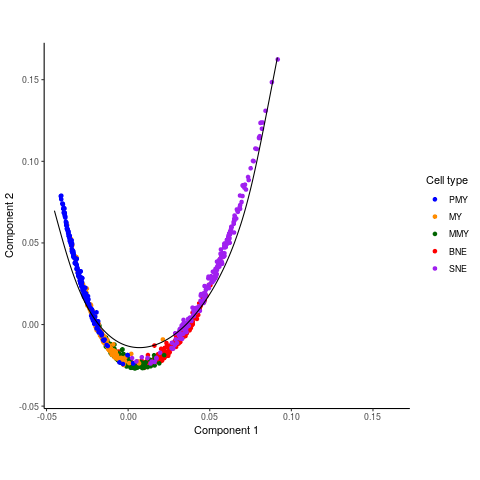

In [4]:
# Trajectory inference using SCORPIUS
%%R -i classes -i DM -o ptime
library(cowplot)
library(SCORPIUS)

# Use diffusion map from Python.
group_name = factor(classes, levels=c('PMY', 'MY', 'MMY', 'BNE', 'SNE'))
trajDM <- infer_trajectory(DM, k=20, maxit=10)
ptime = trajDM$time
draw_trajectory_plot(DM, progression_group=group_name, path=trajDM$path) +  labs(color='Cell type') + 
    scale_color_manual(values=c('blue', 'darkorange', 'darkgreen', 'red', 'purple'))

In [5]:
ptime = np.array(ptime)
# Class 0 should have smaller pseudotimes than class 4.
if ptime[Y == 0].mean() > ptime[Y == 4].mean():
    ptime = 1 - ptime
    
# Sort the samples according to pseudotime.
ptime_sorted_idx = np.argsort(ptime)
ptime_sorted = np.sort(ptime)
classes_sorted = classes[ptime_sorted_idx]
Y_sorted = Y[ptime_sorted_idx]
ptime_diff = ptime_sorted[1:]- ptime_sorted[:-1]

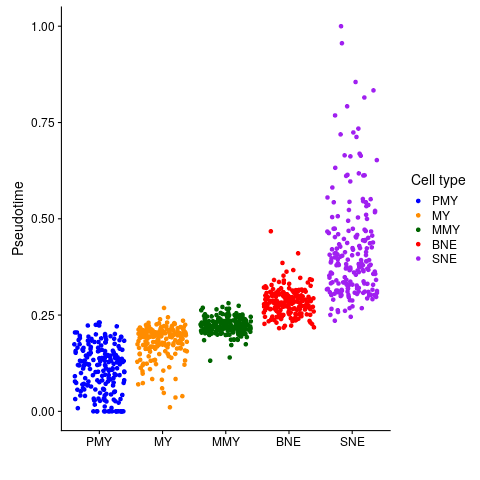

In [6]:
%%R -i ptime
df = data.frame(DM=DM, time=ptime, celltype=group_name)

ggplot(df, aes(celltype, time, color=celltype)) + geom_jitter() +
    theme(axis.text.x = element_text(angle = 0, hjust =0.5)) +
    labs(x='', y='Pseudotime', color='Cell type') + 
    scale_color_manual(values=c('blue', 'darkorange', 'darkgreen', 'red', 'purple'))

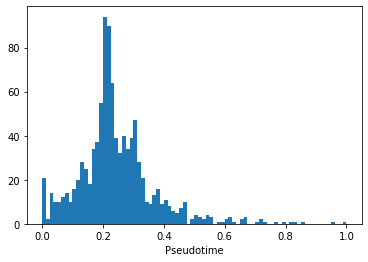

In [7]:
plt.hist(ptime_sorted, bins=80);
plt.xlabel('Pseudotime')
plt.show()

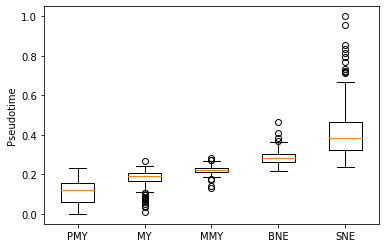

In [8]:
uf.boxplot_ptime(ptime_sorted, Y_sorted)

### EM algorithm

In [9]:
# Rescale the pseudotime differences.
ptime_diff_max = 1
ptime_diff_rescaled = ptime_diff_max * (ptime_diff - np.max(ptime_diff)) / (np.max(ptime_diff) - 
                                                                            np.min(ptime_diff)) + ptime_diff_max

Set $\lambda_{kk} := \frac{\ln(2)}{\mathrm{median}_k}$, where $\mathrm{median}_k$ is the median pseudotime difference within class $k$. 

In [10]:
# Rescaled lambda
med = []
for i in range(5):
    ptime_class = ptime_sorted[np.where(Y_sorted == i)[0]]
    ptime_class_diff = ptime_class[1:] - ptime_class[:-1]
    ptime_class_diff_rescaled = ptime_diff_max * (ptime_class_diff - 
                                                  np.max(ptime_diff)) / (np.max(ptime_diff)
                                                                         - np.min(ptime_diff)) + ptime_diff_max
    med.append(np.median(ptime_class_diff_rescaled))

lmbda_fix = (np.log(2)/med)[:4]

print(med)
print(lmbda_fix)

[0.006188029161409925, 0.003998668149053919, 0.00236868069233076, 0.004328838376772448, 0.012550668554231037]
[112.01420719 173.3445124  292.63006314 160.12313702]


In [11]:
ptime_diff = ptime_diff_rescaled
lmbda_max = 300

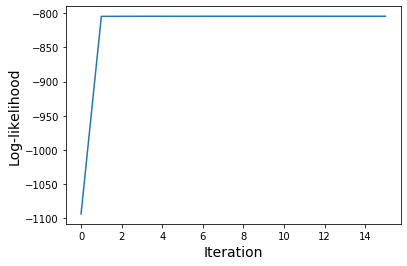

In [12]:
p, lmbda, p_hist, lmbda_hist, loglik_hist = hmmem.EM_algorithm(lmbda_fix, lmbda_max, ptime_diff, Y_sorted, tol=1e-8)

plt.figure()
plt.plot(range(len(loglik_hist)) , loglik_hist)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Log-likelihood', fontsize=14)
plt.show()

### Results

In [13]:
print(p)
print(lmbda)
tm = mat.transition_matrix_fixed_lmbda(p, lmbda, lmbda_fix, ptime_diff)

[[0.99566465 0.00433535]
 [0.99834924 0.00165076]
 [0.99577975 0.00422025]
 [0.98943156 0.01056844]]
[ 192.81027212 2873.94168459  347.08942013   37.592513  ]


In [14]:
Z, T1, T2 = uf.viterbi(Y_sorted, tm)
# Latent labels
print(Z)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

In [15]:
M = Z[:-1] + Z[1:]
idx = []
for i in range(1, 9, 2):
    idx.append(np.where(M == i)[0][0])

classes_new = np.zeros(len(classes))
classes_new[ptime_sorted_idx[idx[0]+1:idx[1]+1]] = 1
classes_new[ptime_sorted_idx[idx[1]+1:idx[2]+1]] = 2
classes_new[ptime_sorted_idx[idx[2]+1:idx[3]+1]] = 3
classes_new[ptime_sorted_idx[idx[3]+1:]] = 4
classes_new = np.array([dev_abb[y] for y in classes_new.astype(int)])
ttimes = uf.transition_times(ptime_sorted, Z)
    
print('Transition indices: ', idx)
print('Accuracy: ', uf.acc(Y_sorted, Z))

Transition indices:  [198, 390, 614, 835]
Accuracy:  0.72


Normalized confusion matrix


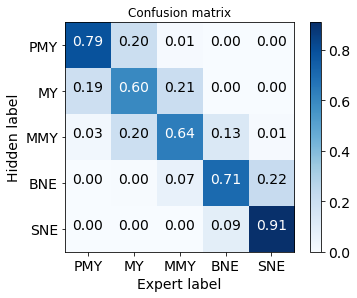

In [16]:
uf.plot_confusion_matrix(confusion_matrix(Z, Y_sorted), classes=['PMY', 'MY', 'MMY', 'BNE', 'SNE'], normalize=True,
                         title='Confusion matrix')
plt.show()

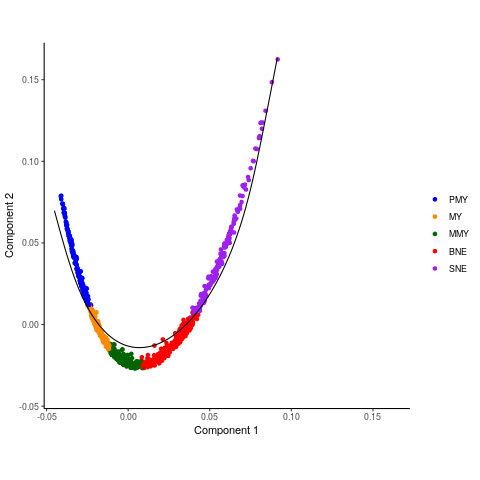

In [17]:
# Classification according to the hidden Markov model
%%R -i classes_new

### Change classes for different dataset. ###
group_name_new = factor(classes_new,
                        levels=c('PMY','MY','MMY','BNE','SNE'))
draw_trajectory_plot(DM, progression_group=group_name_new, path=trajDM$path) +  labs(color='') + 
scale_color_manual(values=c('blue', 'darkorange', 'darkgreen', 'red', 'purple'))

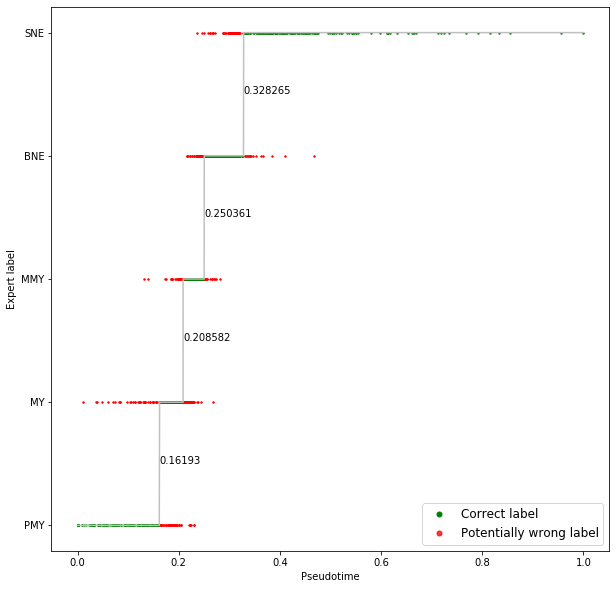

In [18]:
uf.plot_compare_labels(ptime_sorted, Y_sorted, Z, ttimes)